In [1]:
import sys
import os
import math

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import numpy as np

sys.path.append('../3_score/')
from optimize import Scores

sys.path.append('../4_analyze/')
from load_data import *
from plotting_tools import *
from crystalcluster import CrystalCluster
from receptor import *

In [2]:
get_ipython().magic(u'matplotlib inline')

In [3]:
dataset = 'pdbbind_combo/P61823'

loaded_data = Structure(dataset, 'self', 'xglide', True, False, w=w,
                        glide_ifp='scaff_dock3', true_ifp='scaff_true3', refined_ifp='scaff_ref3')

In [10]:
sigmoid = lambda x: 1.0/(1+math.exp(-10*(x-0.7)))
sq = lambda x: x**2

w_mat = load_ss_matrix(dataset, m_f=sigmoid, min_val=1, scale=3)
prev_mat = np.ones(w_mat.shape)

In [80]:
#rings = {1:[0,8,10,15],2:[4,5]}
rings = {1:[0,8,10,15],2:[4],3:[5]}
aro_mat = np.zeros(w_mat.shape)
for i in range(w_mat.shape[0]):
    for j in range(w_mat.shape[1]):
        for r,r_list in rings.items():
            if i in r_list and j in r_list:
                aro_mat[i,j] = 20
                break
            else:
                aro_mat[i,j] = 1

In [81]:
#mcss_mat = load_ss_matrix(dataset, m_f=sigmoid, min_val=0, scale=1)
symm = np.zeros(w_mat.shape)
for i in range(w_mat.shape[0]):
    for j in range(w_mat.shape[1]):
        symm[i,j] = aro_mat[min(i,j),max(i,j)]
        symm[j,i] = aro_mat[min(i,j),max(i,j)]

[1, 2, 3, 6, 7, 9, 11, 12, 13, 14, 16, 17, 18, 19, 0, 8, 10, 15, 5, 4]


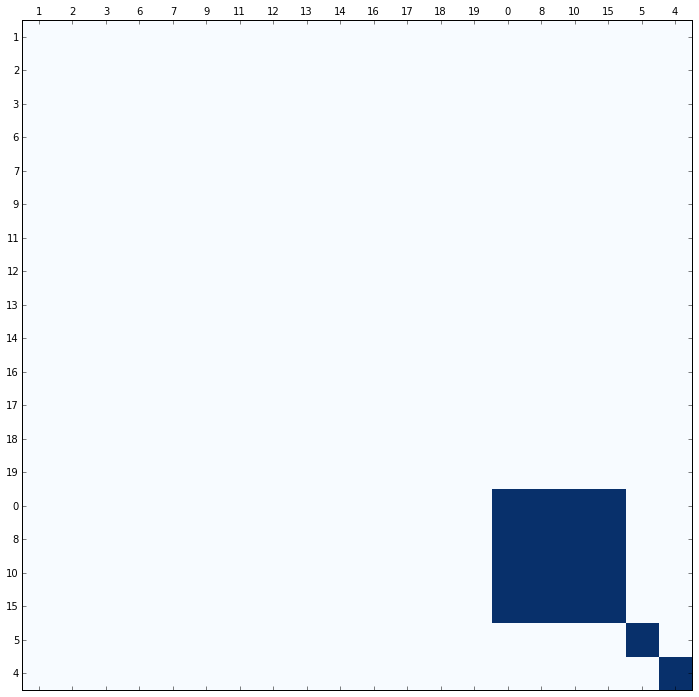

In [82]:
import matplotlib.cm as cm
from sklearn.cluster import KMeans
        
nc = 4
kmeans = KMeans(n_clusters=nc, random_state=0).fit(symm)
#print kmeans.labels_
new_order = sorted(range(symm.shape[0]), key=lambda x: kmeans.labels_[x])
clusters = {
    i : sorted([ss for ss in range(symm.shape[0]) if kmeans.labels_[ss] == i]) for i in range(nc) }
#print clusters
print new_order
new_matrix = np.zeros(symm.shape)
for i in range(new_matrix.shape[0]):
    for j in range(new_matrix.shape[1]):
        new_matrix[i,j] = symm[new_order[i],new_order[j]]
        new_matrix[j,i] = symm[new_order[i],new_order[j]]

fig, ax = plt.subplots()
sq_size = 0.6
fig.set_size_inches(sq_size*symm.shape[0], sq_size*symm.shape[1], forward=True)

ax.matshow(new_matrix, cmap=cm.Blues)
ax.set_yticklabels(new_order)
ax.set_xticklabels(new_order)
plt.xticks(np.arange(min(new_order), max(new_order)+1, 1.0))
plt.yticks(np.arange(min(new_order), max(new_order)+1, 1.0))
#ax.set_xticks(np.arange(1), minor=False)
#plt.imshow(mcss_mat)#, cmap='hot', interpolation='nearest')
plt.show()

18.6799584542 2.1365
0 1 18.6799584542 2.1365
1 1 18.6799584542 2.1365
2 1 18.6799584542 2.1365
3 1 18.6799584542 2.1365
4 1 18.6799584542 2.1365


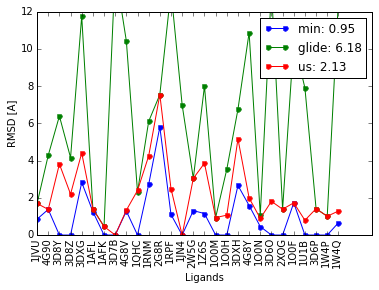

In [85]:
g = 1.3#*20
n = 100

score_input = {l: p.poses for l, p in loaded_data.docked_poses.items()}
#mat3 = np.ones(mat.shape)
ligs0 = ['1JN4','1QHC','1U1B','2XOG']
ligs1 = ['1AFK','1AFL','1O0H','1O0F','1Z6S','2W5G']
ligs2 = ['1JVU','1O0M','1RPF','1W4P','1W4Q']
ligs3 = [l for l in score_input.keys() if l not in ligs0+ligs1+ligs2]
#equal_count = []
#for i in range(3):
#    equal_count.extend([ligs0[i], ligs1[i], ligs2[i], ligs3[i]])
all_ligs = score_input.keys()
all_scores = Scores(score_input, all_ligs, n, aro_mat, gscore_weight=g)

ligset = LigandSet([l for l, p in all_scores.optimized_scores.items()], 
                   [p.rank for l,p in all_scores.optimized_scores.items()], loaded_data.docked_poses)
ligset.plot_final_rmsds(n=n)

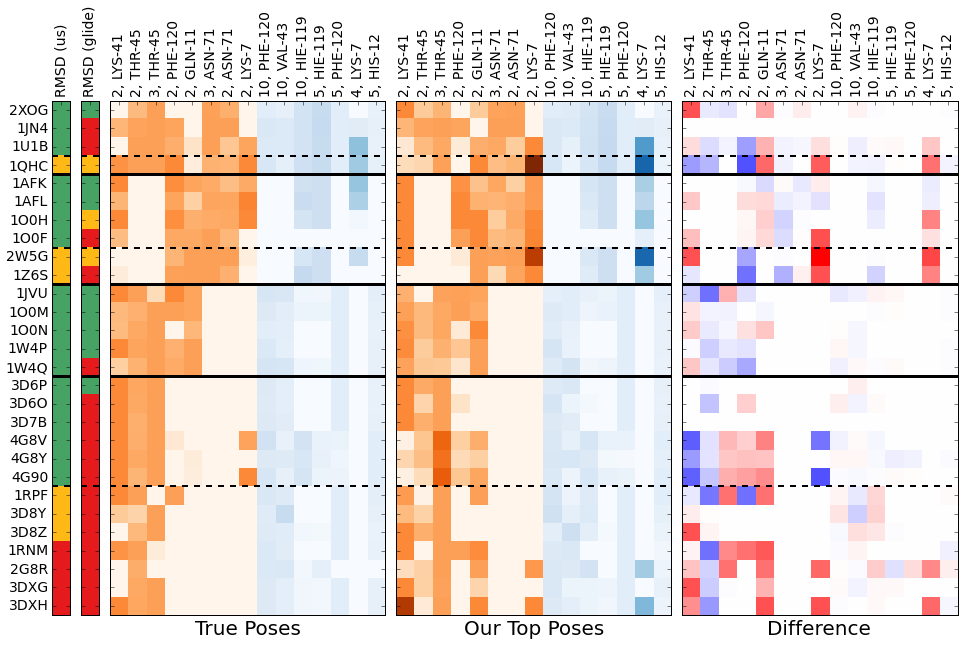

In [86]:
clus_true = Cluster({l:loaded_data.true_pose_cluster.poses[l] for l in ligset.us_top.poses})
cc_true = CrystalCluster(clus_true, 4, [i for i in range(15)],
                         ligset.us_top, ligset.get_top_cluster(1))

cc_true.show_side_by_side(num_i=15, title=dataset.split('/')[1])

In [87]:
phys_score, data_score, interactions = ligset.us_top.score_breakdown(g, aro_mat)
print 'physics score:', phys_score
print 'data score:', data_score

physics score: 8.61760714286
data score: 10.0623513113


In [88]:
clus_true.export('true-out', dataset)
ligset.us_top.export('us-top-out',dataset)

In [ ]:
','.join([str(j) for j in ''])